In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
from tqdm import trange

warnings.filterwarnings('ignore')

(0.870084518145366, 0.023165397394889924, 19)


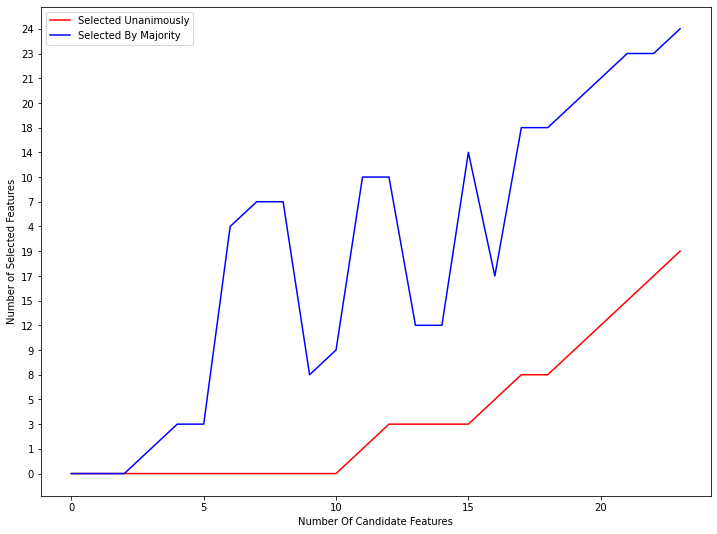

In [24]:
test = pd.read_csv('../Results/UNSW-NB15/Set_F1_DNN.csv', index_col=0)
print(test.iloc[1, 23])
inter = []
vote = []
for i in range(24):
    inter.append(test.iloc[1, i].translate({ord(i): None for i in "() "}).split(',')[2])
    vote.append(test.iloc[2, i].translate({ord(i): None for i in "() "}).split(',')[2])
plt.figure(figsize=(12, 9))
plt.plot(range(24), inter, color='red', linestyle='-', label='Selected Unanimously')
plt.plot(range(24), vote, color='blue', linestyle='-', label='Selected By Majority')
plt.xlabel('Number Of Candidate Features')
plt.ylabel('Number of Selected Features')
plt.legend()
plt.savefig('../Evaluation/UNSW-NB15/method_2/Set_Select.jpg')

In [3]:
# Load Data
train_raw = pd.read_csv('../Data/KDDCUP99/train.csv')
print(train_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal.':
        return 0
    else:
        return 1
train_X = train_raw.drop(['type'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['type'].apply(LabelEncode)

# Normalize data with min, max of training data
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

train_X1.fillna(0, inplace=True)

(494021, 42)
(494021, 38)


In [4]:
# correlation based feature selection
corr = train_X1.corr().abs()

threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > threshold:
            redundant.append((i, j))

train_X2 = train_X1.copy()
train_X2['type'] = train_Y
corr2 = train_X2.corr().abs()

corr3 = corr2['type'].iloc[:-1].copy()
drop = []

#! modify
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)

['num_compromised', 'hot', 'srv_count', 'srv_serror_rate', 'srv_rerror_rate', 'serror_rate', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'rerror_rate']
(494021, 25)


In [5]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
subset_all = pd.read_csv('../Results/KDDCUP99/Feature_sets.csv').values

In [7]:
union_all = []
intersection_all = []
qourum_all = []

for k in trange(1, train_X1.shape[1]+1):
    unions = []
    intersections = []
    qourums = []
    for c in train_X1.columns:
        candidates = subset_all[:, 1:k+1]
        count = np.count_nonzero(candidates == c)
        if count > 0:
            unions.append(c)
        if count > len(subset_all) / 2:
            qourums.append(c)
        if count == len(subset_all):
            intersections.append(c)
    union_all.append(unions)
    intersection_all.append(intersections)
    qourum_all.append(qourums)

100%|██████████| 25/25 [00:00<00:00, 8355.85it/s]


In [10]:
set_all = []
set_all.append(union_all)
set_all.append(intersection_all)
set_all.append(qourum_all)
print(len(set_all))
print(len(set_all[1]))
pd.DataFrame(set_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_Feature_sets.csv')

3
25


In [11]:
cv_times_all = []
f1_all = []
model = LogisticRegression(max_iter=10000, random_state=0, n_jobs=-1)
for all in [union_all, intersection_all, qourum_all]:
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[all[k]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))

    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [02:03<00:00,  4.94s/it]


In [12]:
pd.DataFrame(cv_times_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_Time_LR.csv')
pd.DataFrame(f1_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_F1_LR.csv')

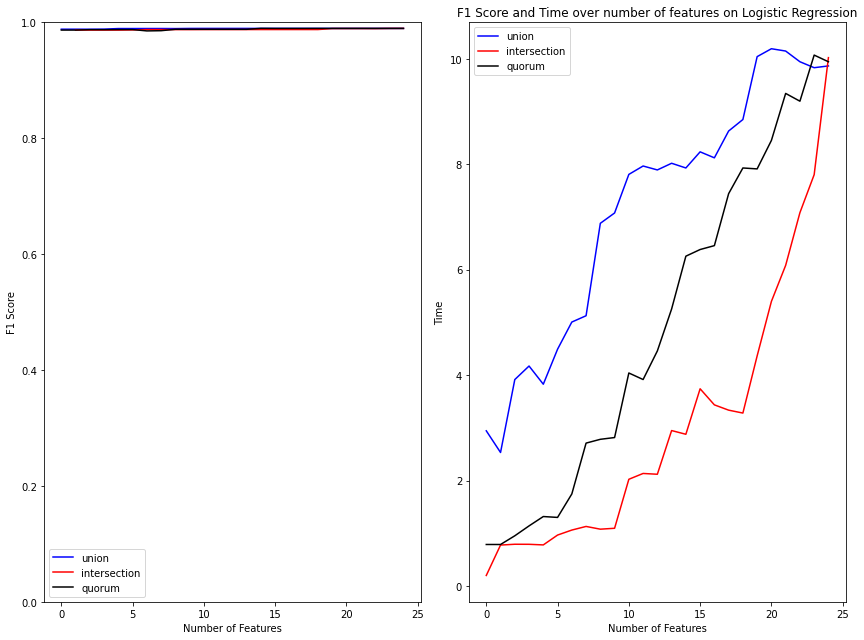

In [13]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Logistic Regression', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='quorum')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='quorum')

plt.legend()

plt.tight_layout()
plt.show()

In [14]:
cv_times_all = []
f1_all = []
model = GradientBoostingClassifier(random_state=0)
for all in [union_all, intersection_all, qourum_all]:
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        # cross validation
        second = time.time()
        cv = cross_val_score(model, train_X1[all[k]], train_Y, scoring='f1', n_jobs=-1)
        second2 = time.time()
        cv_times.append(second2 - second)
        f1s.append((cv.mean(), cv.std()))

    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [10:17<00:00, 24.70s/it]


In [15]:
pd.DataFrame(cv_times_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_Time_GB.csv')
pd.DataFrame(f1_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_F1_GB.csv')

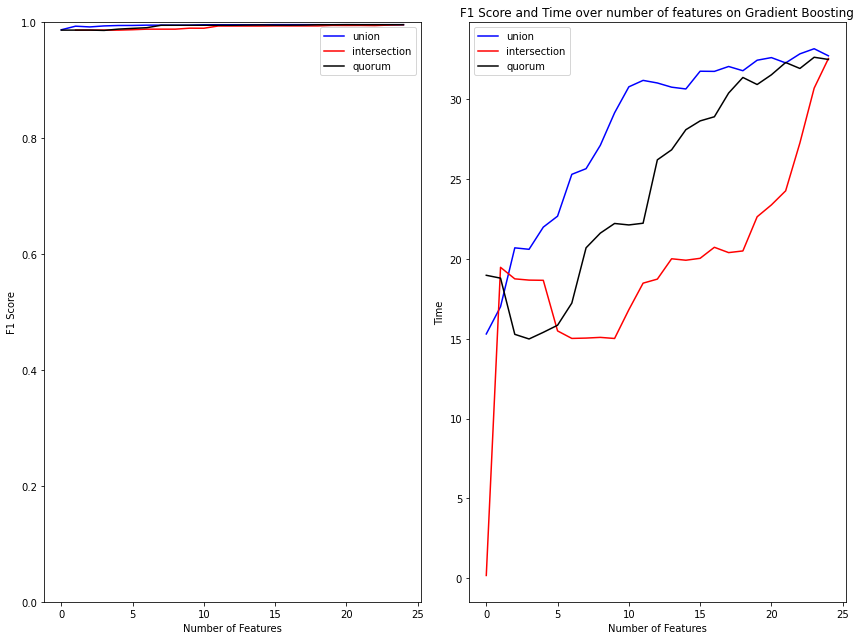

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Gradient Boosting', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='quorum')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='quorum')

plt.legend()

plt.tight_layout()
plt.show()

In [8]:
from keras import Sequential, layers, losses, metrics, callbacks
from sklearn.model_selection import StratifiedKFold
unpatch_sklearn()

In [9]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [10]:
cv_times_all = []
f1_all = []
kf = StratifiedKFold(shuffle=True, random_state=0)
callback = callbacks.EarlyStopping(patience=3, min_delta=0.1, restore_best_weights=True)
for all in [union_all, intersection_all, qourum_all]:
    cv_times = []
    f1s = []
    for k in trange(train_X1.shape[1]):
        if len(all[k]) > 0:
            model = ModelCreate((len(all[k]),))
            # cross validation
            j = 0
            cv_time = 0
            cv = np.zeros(shape=5)
            train_X2 = train_X1[all[k]].copy()
            for train_index, test_index in kf.split(train_X2, train_Y):
                x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
                y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

                second = time.time()
                model.fit(x_train_fold.values, y_train_fold.values, batch_size=1024, validation_data=(x_test_fold, y_test_fold), epochs=30, callbacks=[callback], verbose=0)
                predict = model.predict(x_test_fold, use_multiprocessing=True)
                predict = np.where(predict < 0.5, 0, 1)
                cv[j] = f1_score(y_test_fold, predict)
                second2 = time.time()
                cv_time += second2 - second
                j += 1
            cv_times.append(cv_time)
            f1s.append((cv.mean(), cv.std()))
        else:
            cv_times.append(0)
            f1s.append((0, 0))
    
    cv_times_all.append(cv_times)
    f1_all.append(f1s)

100%|██████████| 25/25 [7:27:10<00:00, 1073.24s/it]  


In [11]:
pd.DataFrame(cv_times_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_Time_DNN.csv')
pd.DataFrame(f1_all, index=['union', 'intersection', 'quorum']).to_csv('../Results/KDDCUP99/Set_F1_DNN.csv')

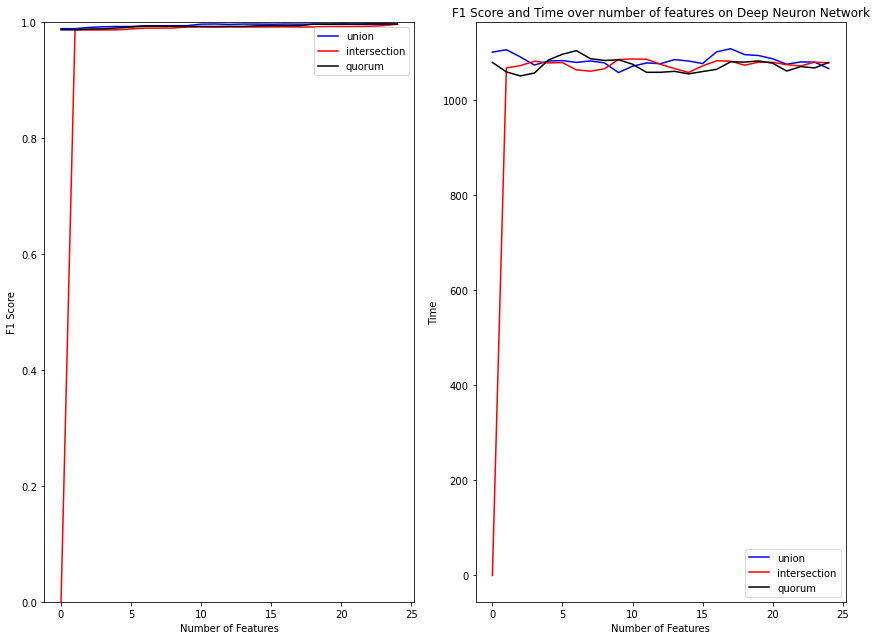

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(12, 9))

plt.title('F1 Score and Time over number of features on Deep Neuron Network', loc='center')
plt.subplot(1, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(train_X1.shape[1]), np.array(f1_all)[0,:,0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[1,:,0], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), np.array(f1_all)[2,:,0], color='black', linestyle='-', label='quorum')

plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(train_X1.shape[1]), cv_times_all[0], color='blue', linestyle='-', label='union')
plt.plot(range(train_X1.shape[1]), cv_times_all[1], color='red', linestyle='-', label='intersection')
plt.plot(range(train_X1.shape[1]), cv_times_all[2], color='black', linestyle='-', label='quorum')

plt.legend()

plt.tight_layout()
plt.show()